In [1]:
import sys
sys.path.append("../src")

In [25]:
from collections import defaultdict
import gzip
import itertools
import joblib
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path
import subprocess
from typing import Iterable, Union

In [3]:
def qiime(*args: Union[str, Path]):
    return subprocess.check_output(["/opt/conda/envs/qiime2-2022.8/bin/qiime", *args])

## Find the Data Files

In [4]:
train_path = Path("/home/dwl2x/work/qiime-classifier")
train_path.mkdir(exist_ok=True)

In [13]:
fasta_files = [Path("/home/dwl2x/work/Datasets/Silva/Silva_138.1.fasta")]
fasta_files

[PosixPath('/home/dwl2x/work/Datasets/Silva/Silva_138.1.fasta')]

In [14]:
taxonomy_files = [Path("/home/dwl2x/work/Datasets/Silva/Silva_138.1.tax.tsv")]
taxonomy_files

[PosixPath('/home/dwl2x/work/Datasets/Silva/Silva_138.1.tax.tsv')]

## Create the Qiime Artifacts

### Sequences Artifact

In [15]:
fasta_file = fasta_files[0]
sequences_artifact = train_path / "0.sequences.qza"

In [16]:
qiime("tools", "import",
      "--input-path", fasta_file,
      "--output-path", sequences_artifact,
      "--type", "FeatureData[Sequence]"
)

b'Imported /home/dwl2x/work/Datasets/Silva/Silva_138.1.fasta as DNASequencesDirectoryFormat to /home/dwl2x/work/qiime-classifier/0.sequences.qza\n'

### Taxonomy Artifact

In [17]:
taxonomy_file = taxonomy_files[0]
taxonomy_artifact = train_path / "0.taxonomy.qza"

In [18]:
qiime("tools", "import",
    "--input-path", taxonomy_file,
    "--output-path", taxonomy_artifact,
    "--input-format", "HeaderlessTSVTaxonomyFormat",
    "--type", "FeatureData[Taxonomy]"
)

b'Imported /home/dwl2x/work/Datasets/Silva/Silva_138.1.tax.tsv as HeaderlessTSVTaxonomyFormat to /home/dwl2x/work/qiime-classifier/0.taxonomy.qza\n'

In [ ]:
qiime("feature-classifier", "fit-classifier-naive-bayes",
    "--i-reference-reads", train_path / "0.sequences.qza",
    "--i-reference-taxonomy", train_path / "0.taxonomy.qza",
    "--o-classifier", train_path / "classifier.qza"
)

In [27]:
qiime("tools", "export",
    "--input-path", train_path / "classifier.qza",
    "--output-path", train_path / "classifier"
)

b'Exported /home/dwl2x/work/qiime-classifier/classifier.qza as TaxonomicClassiferTemporaryPickleDirFmt to directory /home/dwl2x/work/qiime-classifier/classifier\n'

In [1]:
!qiime tools export \
    --input-path /tmp/qiime-artifacts/classifier.qza \
    --output-path /tmp/qiime-artifacts/classifier

Exported /tmp/qiime-artifacts/classifier.qza as TaxonomicClassiferTemporaryPickleDirFmt to directory /tmp/qiime-artifactsclassifier


In [193]:
len(BASES + INCOMPLETE_BASES)

15

---

In [5]:
# from deepdna.data import dataset
from tqdm.contrib.concurrent import process_map
from tqdm.auto import tqdm
import time

### Load Model

In [6]:
def find_fastas_and_taxonomies(path: str):
    path = Path(path)
    fastas = []
    taxas = []
    for f in path.iterdir():
        if str(f).endswith(".fasta"):
            fastas.append(f)
        elif str(f).endswith(".tax.tsv"):
            taxas.append(f)
    fastas.sort()
    taxas.sort()
    return zip(fastas, taxas)

In [7]:
def read_fasta_and_taxonomies(fasta_path, tax_path):
    fasta_file = open(fasta_path)
    tax_file = open(tax_path)
    tax_map = {}
    for line in tax_file:
        identifier, label = line.strip().split('\t')
        tax_map[identifier] = label
    sequences = []
    labels = []
    header = fasta_file.readline().strip()
    while header:
        identifier = header[1:].split(' ')[0]
        sequence = fasta_file.readline().strip()
        sequences.append(sequence)
        labels.append(tax_map[identifier])
        header = fasta_file.readline().strip()
    fasta_file.close()
    tax_file.close()
    return sequences, labels

In [8]:
# Extract the tar first...
model = joblib.load(os.path.join(train_path, "classifier/sklearn_pipeline.pkl"))

In [9]:
files = list(find_fastas_and_taxonomies("/home/dwl2x/work/Datasets/Synthetic/Nachusa/test"))
len(files)

2100

In [15]:
t = time.time()
def run(args):
    fasta_file, tax_file = args
    sequences, labels = read_fasta_and_taxonomies(fasta_file, tax_file)
    pred = model.predict(sequences)
    return np.sum(pred == labels) / len(labels)
accuracies = process_map(run, files, max_workers=64)
print(time.time() - t)
accuracies = np.array(accuracies)

2100/2100

0it [00:00, ?it/s]

654.5265138149261


In [19]:
len(accuracies)

2100

In [20]:
print("Qiime:")
print("Evaluated across 210 Samples (10 subsamples of 1,000 sequences each):")
print("Metrics are computed across 2,100 subsamples.")
print(f"Min: {np.min(accuracies):%}")
print(f"Mean: {np.mean(accuracies):%}")
print(f"Max: {np.max(accuracies):%}")
print(f"STD: {np.std(accuracies):%}")

Qiime (Naive Predictions):
Evaluated across 210 Samples (10 subsamples of 1,000 sequences each):
Metrics are computed across 2,100 subsamples.
Min: 48.000000%
Mean: 80.838476%
Max: 86.700000%
STD: 3.859346%


In [23]:
np.savetxt("./logs/qiime_taxonomy_accuracy.txt", accuracies)

In [29]:
accuracies_dnabert_naive = np.loadtxt("./logs/dnabert_taxonomy_naive_accuracy.txt")
accuracies_dnabert_bertax = np.loadtxt("./logs/dnabert_taxonomy_bertax_accuracy.txt")
accuracies_dnabert_topdown = np.loadtxt("./logs/dnabert_taxonomy_topdown_accuracy.txt")
accuracies_setbert = np.loadtxt("./logs/setbert_taxonomy_naive_full_accuracy.txt")

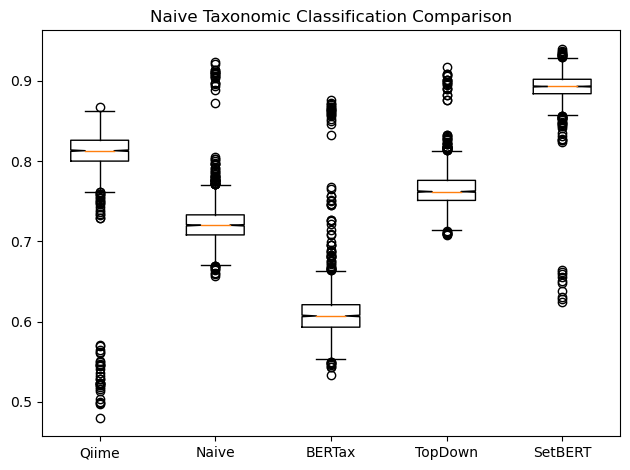

In [34]:
plt.title("Taxonomic Classification Comparison")
plt.boxplot([
    accuracies,
    accuracies_dnabert_naive,
    accuracies_dnabert_bertax,
    accuracies_dnabert_topdown,
    accuracies_setbert], notch=True, labels=["Qiime", "Naive", "BERTax", "TopDown", "SetBERT"])
plt.tight_layout()
plt.show()